In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import os, sys

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [52]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 30  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [12]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [13]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('heb.txt', encoding='utf-8'):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break
        
    if t< 5:
        print(line)

    # input and target are separated by tab
    if '\t' not in line:
        continue

    # split up the input and translation
    input_text, translation = line.rstrip().split('\t')
    
    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))
    

Hi.	היי.

Hi.	אהלן.

Run!	רוץ!

Run!	רוצי!

num samples: 10000


Now examine:

In [16]:
print("Example 17")
print("Input text: ", input_texts[17])
print("Target text: ", target_texts[17])
print("Target text inputs: ", target_texts_inputs[17])

Example 17
Input text:  I see.
Target text:  אני מבין. <eos>
Target text inputs:  <sos> אני מבין.


In [17]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [21]:
# Examining the input sequences
input_sequences[:10]

[[727], [727], [184], [184], [184], [36], [275], [275], [53], [276]]

Each **input** word receives a designated index. The first two are the same because both represent the word "Hi" 

In [22]:
# get the word to index mapping for input language (dictionary of each word and its frequency)
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2413 unique input tokens.


In [23]:
# Examining word_index
word2idx_inputs

{'i': 1,
 'tom': 2,
 'it': 3,
 "i'm": 4,
 'is': 5,
 'you': 6,
 'was': 7,
 'me': 8,
 'a': 9,
 "it's": 10,
 'we': 11,
 'he': 12,
 'this': 13,
 'that': 14,
 'go': 15,
 "don't": 16,
 'they': 17,
 'are': 18,
 'can': 19,
 'up': 20,
 'the': 21,
 'do': 22,
 "you're": 23,
 "we're": 24,
 'be': 25,
 'she': 26,
 'come': 27,
 "tom's": 28,
 'him': 29,
 'in': 30,
 'here': 31,
 'now': 32,
 'get': 33,
 'like': 34,
 "that's": 35,
 'who': 36,
 'love': 37,
 'keep': 38,
 'to': 39,
 'my': 40,
 'am': 41,
 'just': 42,
 "let's": 43,
 'got': 44,
 'need': 45,
 'stop': 46,
 'have': 47,
 'please': 48,
 "they're": 49,
 'take': 50,
 'back': 51,
 'did': 52,
 'help': 53,
 "i'll": 54,
 'not': 55,
 'out': 56,
 'on': 57,
 'us': 58,
 'try': 59,
 'stay': 60,
 'home': 61,
 "he's": 62,
 'hate': 63,
 'let': 64,
 'your': 65,
 'look': 66,
 'how': 67,
 'so': 68,
 'may': 69,
 'down': 70,
 'will': 71,
 'want': 72,
 'there': 73,
 'know': 74,
 'again': 75,
 'them': 76,
 'leave': 77,
 'felt': 78,
 'one': 79,
 'see': 80,
 'wait': 81,


In [24]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
max_len_input

5

I need to use max, since I don't want to loose information (as opposed to sentiment analysis). However, if there is a long tail I better trucket it, so I don't have to many wasted calculation

In [25]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='.')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [29]:
# Examining the target sequences
target_sequences[:10]

[[147, 1],
 [1428, 1],
 [2412, 1],
 [2413, 1],
 [2414, 1],
 [723, 1],
 [1429, 1],
 [2415, 1],
 [942, 1],
 [550, 1]]

Each **target** word receives a designated index. The '1' is the '<eos>' that exits in every target.

In [30]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 6114 unique output tokens.


In [31]:
# Examining word_index. This tokenuzer relates to both 'target' and 'target_inputs' (that's why it includes both <eos> and <sos>
word2idx_outputs

{'<eos>': 1,
 '<sos>': 2,
 'אני': 3,
 'תום': 4,
 'זה': 5,
 'את': 6,
 'הוא': 7,
 'הם': 8,
 'היה': 9,
 'לא': 10,
 'אתה': 11,
 'לי': 12,
 'אנו': 13,
 'אל': 14,
 'היא': 15,
 'מי': 16,
 'אותי': 17,
 'אוהב': 18,
 'יש': 19,
 'עכשיו': 20,
 'אתם': 21,
 'יכול': 22,
 'לך': 23,
 'הייתי': 24,
 'על': 25,
 'זאת': 26,
 'לתום': 27,
 'האם': 28,
 'אנחנו': 29,
 'אוהבת': 30,
 'בבקשה': 31,
 'שלי': 32,
 'בוא': 33,
 'תן': 34,
 'אותו': 35,
 'אותך': 36,
 'רוצה': 37,
 'רק': 38,
 'בואו': 39,
 'כך': 40,
 'זה?': 41,
 'כמה': 42,
 'ללכת': 43,
 'יותר': 44,
 'מה': 45,
 'שונא': 46,
 'לו': 47,
 'כל': 48,
 'נראה': 49,
 'אינני': 50,
 'צריך': 51,
 'יודע': 52,
 'יכולה': 53,
 'יכולים': 54,
 'לנו': 55,
 'כאן': 56,
 'אחד': 57,
 'טום': 58,
 'טוב': 59,
 'קח': 60,
 'פה': 61,
 'זו': 62,
 'שוב': 63,
 'חייב': 64,
 'בסדר': 65,
 'בואי': 66,
 'אותם': 67,
 'פשוט': 68,
 'היו': 69,
 'תהיה': 70,
 'הביתה': 71,
 'שונאת': 72,
 'שם': 73,
 'מרגיש': 74,
 'פנימה': 75,
 'מדי': 76,
 'הנה': 77,
 'מאוד': 78,
 'בזה': 79,
 'ראיתי': 80,
 'תפסיק': 81,
 'ש

In [32]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [33]:
num_words_output

6115

**!!! get back later to understand**

In [34]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
max_len_target

7

The max_len_target may be larger than this one if the data is really small, so I may consider enlarge it manually.

In [36]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
print()
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
print()
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_targets[0])
print("decoder_inputs.shape:", decoder_targets.shape)

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [  0   0   0   0 727]

decoder_inputs[0]: [  2 147   0   0   0   0   0]
decoder_inputs.shape: (10000, 7)

decoder_inputs[0]: [147   1   0   0   0   0   0]
decoder_inputs.shape: (10000, 7)


In [ ]:
# # store all the pre-trained word vectors
# print('Loading word vectors...')
# word2vec = {}
# with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
#   # is just a space-separated text file in the format:
#   # word vec[0] vec[1] vec[2] ...
#   for line in f:
#     values = line.split()
#     word = values[0]
#     vec = np.asarray(values[1:], dtype='float32')
#     word2vec[word] = vec
# print('Found %s word vectors.' % len(word2vec))




# # prepare embedding matrix
# print('Filling pre-trained embeddings...')
# num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
# embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# for word, i in word2idx_inputs.items():
#   if i < MAX_NUM_WORDS:
#     embedding_vector = word2vec.get(word)
#     if embedding_vector is not None:
#       # words not found in embedding index will be all zeros.
#       embedding_matrix[i] = embedding_vector

In [37]:
# This is instead of the row in the embedding matrix. If I use pre-trained I don't need this line
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

For now I am not using a pre-trained

In [38]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  #weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [40]:
len(input_texts)

10000

In [39]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output #########################################
  ),
  dtype='float32'
)

In [41]:
# Remind myself what decoder_targets is
decoder_targets

array([[ 147,    1,    0, ...,    0,    0,    0],
       [1428,    1,    0, ...,    0,    0,    0],
       [2412,    1,    0, ...,    0,    0,    0],
       ..., 
       [   4,  161,  177, ...,    0,    0,    0],
       [   4,  161,   73, ...,    0,    0,    0],
       [  58,  161,  409, ...,    0,    0,    0]])

In [42]:
# assign the values. So the one hot has three dimensions: the first is the 10000 data rows, the second is the 7 words of the 
# target, and the third is the 'num_word_output' which is the number of unique words in the target. So the 'word' varaible is the
# value in the 'decoder_targets', for example 147, so this will be the index in the third dimension of the one_hot
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [43]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))

embed_encod = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True, # Because I use return_state=True I can have h and c, otherwise I would get only the encoder outputs
  dropout=0.3 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(embed_encod)
# encoder_outputs, h = encoder(embed_encod) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,)) # Important. I am using the max_len of the target(!) here

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  dropout=0.3 # dropout not available on gpu
)
# Below - like the encoder receives an input of 'embed_encode', here are two inputs: 1. the target text, represented by 
# decoder_input_x, 2. the the encoder_state (h,c) from the encoder
# Also, I don't need the h and c as outputs (as I willl need them in the prediction)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [44]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [45]:
# Compile the model
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 100)       241400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 7, 256)       1565440     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [53]:
# Train the model
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5572 - acc: 0.8790 - val_loss: 2.7281 - val_acc: 0.6997
Epoch 2/30
8000/8000 [==============================] - 38s 5ms/step - loss: 0.5746 - acc: 0.8783 - val_loss: 2.7797 - val_acc: 0.6950
Epoch 3/30
8000/8000 [==============================] - 37s 5ms/step - loss: 0.5832 - acc: 0.8799 - val_loss: 2.7725 - val_acc: 0.6958
Epoch 4/30
8000/8000 [==============================] - 38s 5ms/step - loss: 0.5863 - acc: 0.8798 - val_loss: 2.7798 - val_acc: 0.6944
Epoch 5/30
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5817 - acc: 0.8803 - val_loss: 2.7723 - val_acc: 0.6968
Epoch 6/30
8000/8000 [==============================] - 38s 5ms/step - loss: 0.5762 - acc: 0.8820 - val_loss: 2.7919 - val_acc: 0.6914
Epoch 7/30
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5688 - acc: 0.8832 - val_loss: 2.7916 - val_acc: 0.6931
Epoch 8

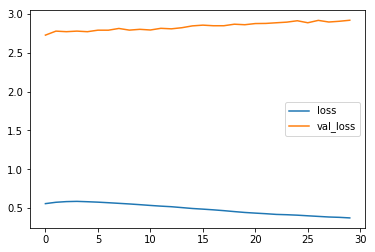

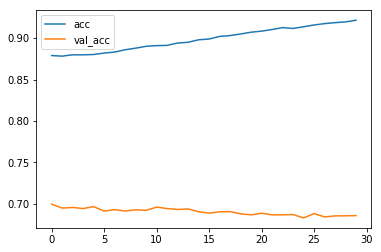

In [55]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

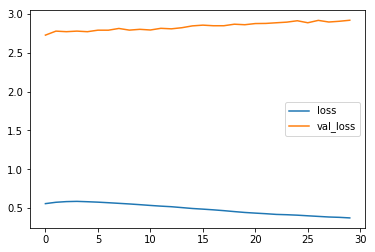

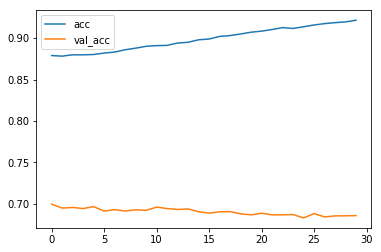

C:\Users\ishay\Anaconda3\lib\site-packages\keras\engine\network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [54]:
# Save model
model.save('s2sv1.h5')

In [56]:
##### Make predictions #####
# We need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone. It is exactly as the encoder in the training model
# From this we will get our initial decoder hidden state (h,c)
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [57]:
# These inputs are placeholders for the output of the encoder_model above
decoder_state_input_h = Input(shape=(LATENT_DIM,)) 
decoder_state_input_c = Input(shape=(LATENT_DIM,)) 
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

In [58]:
decoder_inputs_single = Input(shape=(1,))
# The single word input (at its time) will be embedded
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [60]:
# this time, we want to keep the states too (h and c of the decoder), to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x, # This is the input of the generated previous word in the prediction
  initial_state=decoder_states_inputs # The h and c states from encoder_model
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru

In [61]:
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

In [63]:
# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states)

In [64]:
# map indexes back into real words
# so we can view the results (it's the opposite, v:k instead k:v)
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [66]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # Create the translation - make prediction 7 (or any target length) times, and each time generate token, h, c
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # output_tokens, h = decoder_model.predict([target_seq] + states_value) # gru

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]
        # states_value = [h] # gru

    return ' '.join(output_sentence)

In [69]:
while True:
    # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    print(input_seq)
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

[[   0    0    0 1218  717]]
-
Input: We've arrived.
Translation: אנחנו הגענו
Continue? [Y/n]Y
[[  0   0   1 228   2]]
-
Input: I miss Tom.
Translation: אני מתגעגעת לתום
Continue? [Y/n]n


In [141]:
example = ["Sit on the chair"]

example_sequences = tokenizer_inputs.texts_to_sequences(example)
print(example_sequences)

[[99, 57, 21]]


In [142]:
example_inputs = pad_sequences(example_sequences, maxlen=max_len_input)
print(example_inputs)
example_translation = decode_sequence(example_inputs)
example_translation

[[ 0  0 99 57 21]]


'שב על זה'